In [2]:
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

# from sklearn.cluster import KMeans, spectral_clustering
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.metrics import silhouette_score, silhouette_samples
from copy import deepcopy

In [5]:
os.chdir("/home/g.esposito/sc2-benchmark")
path = os.getcwd()

log_folders = [file_path for file_path in os.listdir("/home/g.esposito/sc2-benchmark") if "L" in file_path and file_path != "LICENSE"]
# print(log_folders)

general_report = pd.DataFrame([])
new_report = pd.DataFrame([])

for layer_conf in log_folders:
    if layer_conf != ".DS_Store":
        folder_path = os.path.join(path,  layer_conf)
        for cnf in [files for files in os.listdir(folder_path) if files != ".DS_Store"]:
            file_path = os.path.join(folder_path, cnf)

            report_path = os.path.join(file_path, "Faulty_boxes_report.csv")
            report = pd.read_csv(report_path)
            report['conf_detail'] = cnf.split("_")[0] if cnf.split("_")[0] != "cnf77" else "teacher_cnf"
            # print(report.columns)
            report['bit_faulty_position'] = np.log2(report['bitmask'])
            report.drop(columns=['Unnamed: 0'], inplace=True)
            general_report = pd.concat([general_report, report], axis=0, ignore_index=True)

            new_path = os.path.join(file_path, "fsim_full_report.csv")
            additional_report = pd.read_csv(new_path)
            additional_report['bit_faulty_position'] = np.log2(report['bitmask'])
            additional_report.drop(columns=['kernel.1','channel.1','row.1','col.1','BitMask', 'Unnamed: 0'], inplace=True)

            indices = additional_report.query("boxes_Crit==0 and boxes_SDC==0 and boxes_Masked == 0").index
            for idx in indices:
                additional_report.loc[idx, 'boxes_Crit'] = additional_report.loc[idx, 'average_golden_boxes']*100

            tot_boxes_per_fault = additional_report['boxes_Crit'] + additional_report['boxes_SDC'] + additional_report['boxes_Masked']
            additional_report['Crit_perc'] = (additional_report['boxes_Crit'] / tot_boxes_per_fault)*100
            additional_report['SDC_perc'] = (additional_report['boxes_SDC'] / tot_boxes_per_fault)*100
            additional_report['masked_perc'] = (additional_report['boxes_Masked'] / tot_boxes_per_fault)*100
            new_report = pd.concat([new_report, additional_report], axis=0, ignore_index=True)


general_report['iou_score'] = general_report['iou score']
general_report.drop(columns="iou score", inplace=True)
general_report.describe()
new_report.head()

,layer,kernel,channel,row,col,bitmask,gold_iou@1,boxes_Crit,boxes_SDC,boxes_Masked,...,average_faulty_boxes,average_target_boxes,Layer,Ffree_Weight,Faulty_weight,Abs_error,bit_faulty_position,Crit_perc,SDC_perc,masked_perc
0,4,0,9,0,1,536870912,68.352722,41.0,463.0,0.0,...,6.00,7.78,4.0,3.180621e+09,2.643750e+09,-0.072471,29.0,8.134921,91.865079,0.00000
1,4,0,6,1,0,16777216,68.352722,59.0,445.0,0.0,...,6.00,7.78,4.0,3.190655e+09,3.207433e+09,0.508409,29.0,11.706349,88.293651,0.00000
2,4,0,18,1,0,16777216,68.352722,25.0,479.0,1.0,...,5.97,7.78,4.0,1.021508e+09,1.038286e+09,-0.083123,29.0,4.950495,94.851485,0.19802
3,4,0,16,0,1,2097152,68.352722,32.0,473.0,0.0,...,5.93,7.78,4.0,3.188764e+09,3.190862e+09,0.031250,29.0,6.336634,93.663366,0.00000
4,4,0,9,1,0,16777216,68.352722,68.0,437.0,0.0,...,6.14,7.78,4.0,1.051498e+09,1.068275e+09,-1.011221,29.0,13.465347,86.534653,0.00000


In [4]:
counter = 0
print(len(general_report.query("F_lab!=G_lab")))
print(len(general_report))

10959
165310


In [5]:
# general_report.query("F_lab!=G_lab").describe()
general_report.query("iou_score < 90 and F_lab==G_lab and confidence_covered==1.0").describe()

,imID,layer,kernel,channel,row,col,bitmask,G_lab,F_count,F_lab,G_count,G_score,T_count,area_ratio,confidence_covered,f_candidate_conf,bit_faulty_position,iou_score
count,149779.000000,149779.000000,149779.000000,149779.000000,149779.000000,149779.000000,1.497790e+05,149779.000000,149779.000000,149779.000000,149779.000000,149779.000000,149779.000000,149779.000000,149779.0,149779.000000,149779.000000,149779.000000
mean,54.534427,2.135513,33.728413,32.080365,1.098285,1.092610,3.489607e+08,26.691719,12.206417,26.691719,10.654004,87.220137,12.971451,103.087944,1.0,85.929447,25.738895,79.572169
std,30.263679,1.619644,50.329173,39.335396,1.493732,1.490995,6.619909e+08,27.985984,7.566747,27.985984,6.427448,9.057881,8.154959,77.104158,0.0,10.686012,3.067692,16.519499
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.048576e+06,1.000000,1.000000,1.000000,1.000000,70.001930,1.000000,1.049869,1.0,60.001081,20.000000,0.000000
25%,26.000000,1.000000,1.000000,2.000000,0.000000,0.000000,1.677722e+07,1.000000,7.000000,1.000000,6.000000,79.080111,7.000000,88.756614,1.0,77.419084,24.000000,77.945493
50%,59.000000,2.000000,16.000000,25.000000,1.000000,1.000000,6.710886e+07,9.000000,11.000000,9.000000,10.000000,89.015961,12.000000,100.184672,1.0,88.323587,26.000000,84.893883
75%,79.000000,4.000000,46.000000,47.000000,1.000000,1.000000,2.684355e+08,56.000000,15.000000,56.000000,13.000000,95.475054,17.000000,113.043478,1.0,95.374730,28.000000,88.123515
max,99.000000,4.000000,255.000000,255.000000,6.000000,6.000000,2.147484e+09,86.000000,42.000000,86.000000,29.000000,99.980754,34.000000,14594.920635,1.0,99.977285,31.000000,89.999377


In [6]:
general_report.query("iou_score < 90 and F_lab==G_lab").groupby(by="layer").count()

,FaultID,imID,kernel,channel,row,col,bitmask,G_lab,f_bb,g_bb,...,F_lab,G_count,G_score,T_count,area_ratio,confidence_covered,f_candidate_conf,conf_detail,bit_faulty_position,iou_score
layer,,,,,,,,,,,,,,,,,,,,,
0,35670,35670,35670,35670,35670,35670,35670,35670,35670,35670,...,35670,35670,35670,35670,35670,35670,35670,35670,35670,35670
1,30166,30166,30166,30166,30166,30166,30166,30166,30166,30166,...,30166,30166,30166,30166,30166,30166,30166,30166,30166,30166
2,20735,20735,20735,20735,20735,20735,20735,20735,20735,20735,...,20735,20735,20735,20735,20735,20735,20735,20735,20735,20735
3,11682,11682,11682,11682,11682,11682,11682,11682,11682,11682,...,11682,11682,11682,11682,11682,11682,11682,11682,11682,11682
4,55441,55441,55441,55441,55441,55441,55441,55441,55441,55441,...,55441,55441,55441,55441,55441,55441,55441,55441,55441,55441


## Regression Task Criticality

In [7]:
print(f'Percentage of critical boxes because of the low iou score: {len(general_report.query("iou_score < 90 and F_lab==G_lab and confidence_covered==1.0"))/len(general_report)}')

Percentage of critical boxes because of the low iou score: 0.906049240820277


Most of the boxes are here reported because of the iou_score which is critical and not for the different label

In [8]:
general_report['confidence_ratio'] = general_report['f_candidate_conf'] / general_report['G_score']
score_report = general_report.query("iou_score < 90 and F_lab==G_lab and confidence_covered==1.0")
# general_report['confidence_ratio'].describe()

While the confidence ratio has a variability around 1 that is low (that means that the confidence of the model in predicting something does not change too much), the iou_score is more sensible.

On the basis of the resilience (iou_score), models  can be ranked with respect to the interquantile distance:
- teacher_cnf
- cnf1
- cnf6
- cnf3
- cnf9
- cnf2
- cnf12

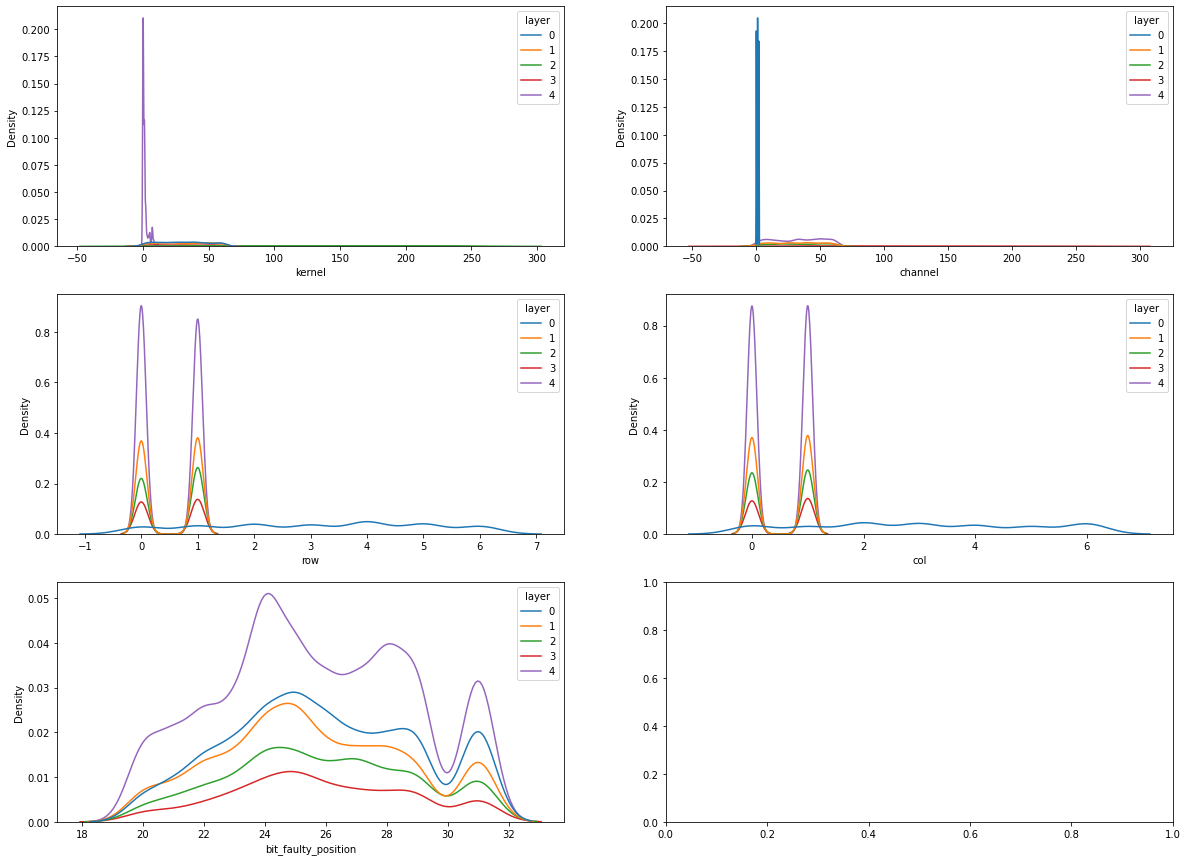

In [10]:
fig, ax = plt.subplots(3,2, figsize=(20,15))
sns.kdeplot(data = score_report[score_report['iou_score']<70], x ='kernel', hue = 'layer', ax=ax[0][0], palette="tab10")
sns.kdeplot(data = score_report[score_report['iou_score']<70], x ='channel', hue = 'layer', ax=ax[0][1], palette="tab10")
sns.kdeplot(data = score_report[score_report['iou_score']<70], x ='row', hue = 'layer', ax=ax[1][0], palette="tab10")
sns.kdeplot(data = score_report[score_report['iou_score']<70], x ='col', hue = 'layer', ax=ax[1][1], palette="tab10")
sns.kdeplot(data = score_report[score_report['iou_score']<70], x ='bit_faulty_position', hue = 'layer', ax=ax[2][0], palette="tab10")

## Area ratio

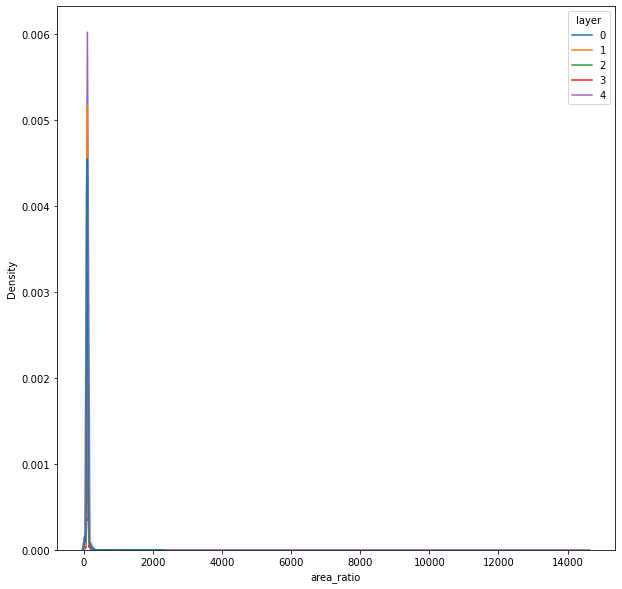

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.kdeplot(ax=ax, data=score_report, x= 'area_ratio', hue='layer', palette="tab10")

In [19]:
score_report[score_report['area_ratio']>200].groupby(by='conf_detail').groups
for key, indices in score_report[score_report['area_ratio']>200].groupby(by='layer').groups.items():
    print(f'{key}: {len(indices)}')

0: 215
1: 150
2: 76
3: 36
4: 500


In [20]:
print(f"number of boxes whose area is the double of the fault free model: {len(score_report[score_report['area_ratio']>200])}")
print(f"which represents the {(len(score_report[score_report['area_ratio']>200]) / len(score_report))*100}% of the total critical boxes")

number of boxes whose area is the double of the fault free model: 977
which represents the 0.6522943803871036% of the total critical boxes


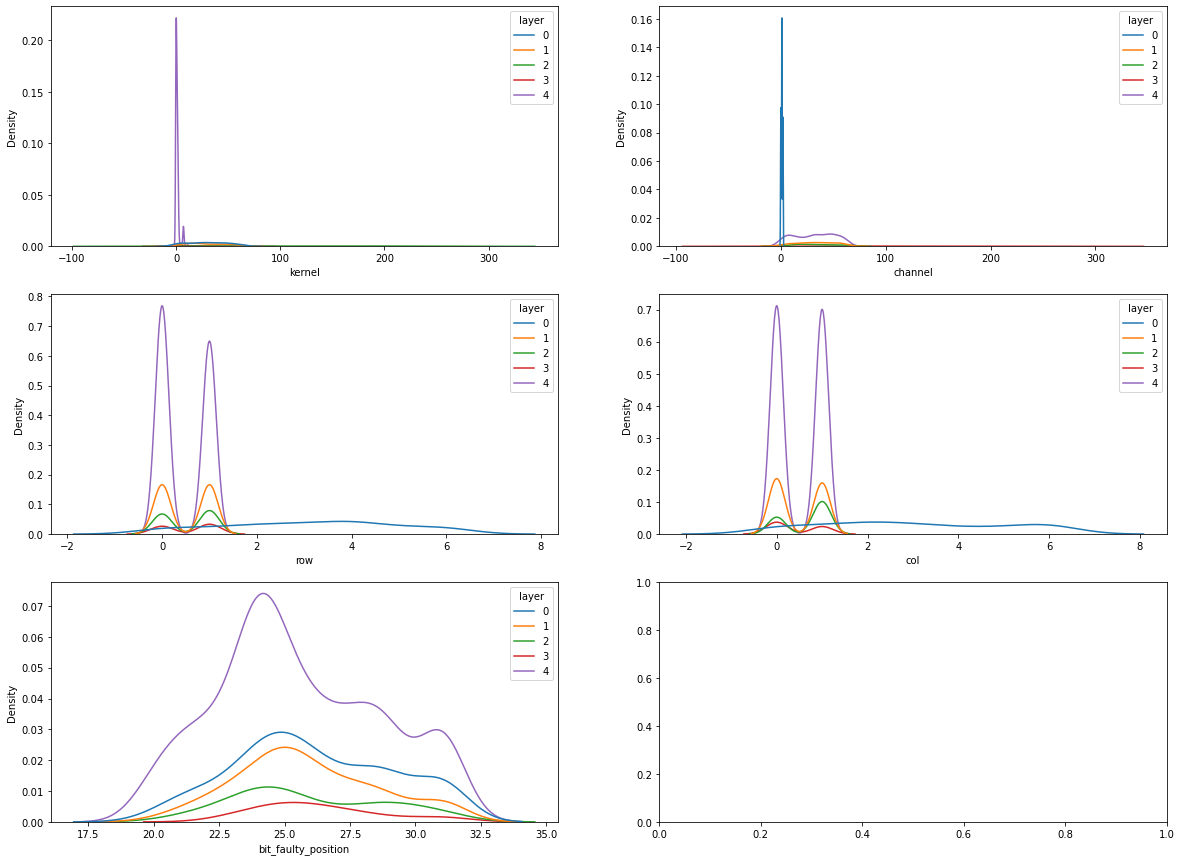

In [21]:
fig, ax = plt.subplots(3,2, figsize=(20,15))
sns.kdeplot(data = score_report[score_report['area_ratio']>200], x ='kernel', hue = 'layer', ax=ax[0][0], palette="tab10")
sns.kdeplot(data = score_report[score_report['area_ratio']>200], x ='channel', hue = 'layer', ax=ax[0][1], palette="tab10")
sns.kdeplot(data = score_report[score_report['area_ratio']>200], x ='row', hue = 'layer', ax=ax[1][0], palette="tab10")
sns.kdeplot(data = score_report[score_report['area_ratio']>200], x ='col', hue = 'layer', ax=ax[1][1], palette="tab10")
sns.kdeplot(data = score_report[score_report['area_ratio']>200], x ='bit_faulty_position', hue = 'layer', ax=ax[2][0], palette="tab10")

In these plots we can see where are the most critical points in terms of area ratio

### Cutting off these outliers let us see the distribution

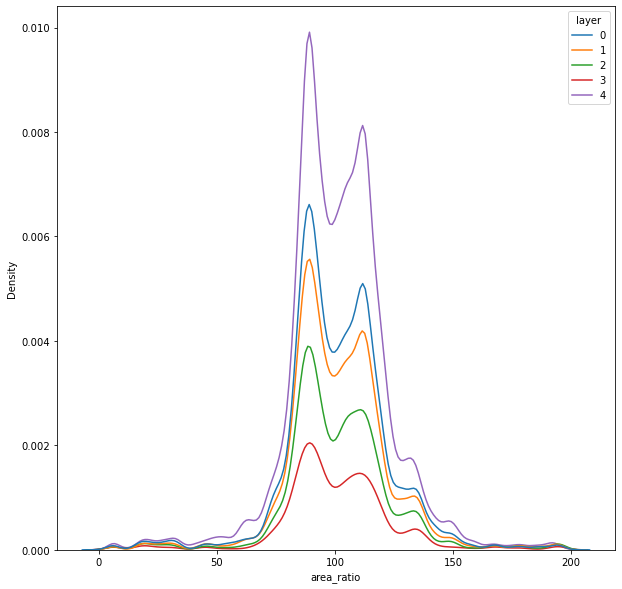

In [23]:
normal_area = score_report[score_report['area_ratio']<200]
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.kdeplot(ax=ax, data=normal_area, x= 'area_ratio', hue='layer', palette="tab10")
ax.grid()
# this is a probability, then it is already normalized. 

## Classification task evaluation

In [24]:
general_report['confidence_ratio'] = general_report['f_candidate_conf'] / general_report['G_score']
score_report = general_report.query("F_lab!=G_lab and confidence_covered==1.0")

## Confidence analysis

In [14]:
general_report['confidence_ratio'] = general_report['f_candidate_conf'] / general_report['G_score']
# score_report = general_report.query("confidence_covered==0.0")
crit_perc_per_layer_per_bit = new_report.groupby(by=["bit_faulty_position", "layer"]).mean()['Crit_perc']/100
general_report['confidence_coverage'] = general_report.groupby(by=['layer', 'bit_faulty_position'])['confidence_covered'].transform(lambda x: x.sum())
general_report['confidence_coverage']

0         106028.082148
1         106028.082148
2         106028.082148
3         106028.082148
4         106028.082148
              ...      
165305              NaN
165306              NaN
165307              NaN
165308              NaN
165309              NaN
Name: confidence_coverage, Length: 165310, dtype: float64

In [42]:
crit_perc_per_layer_per_bit = new_report.groupby(by=["bit_faulty_position", "layer"]).mean()['boxes_Crit']

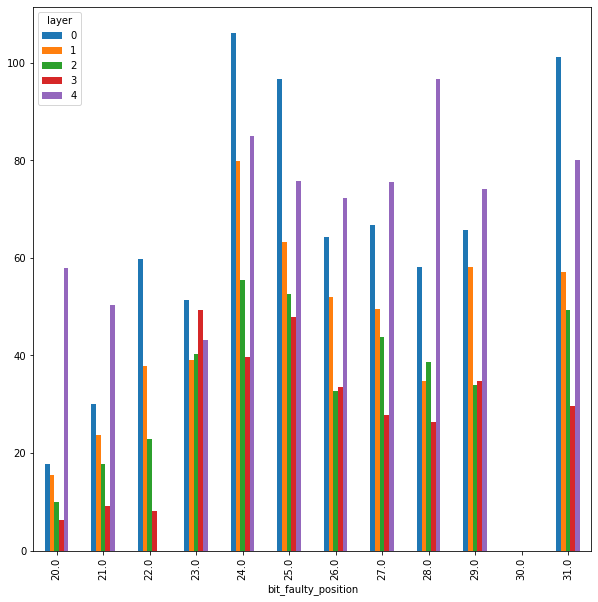

In [43]:
grouped_confidence = general_report.groupby(by=['layer', 'bit_faulty_position'])['confidence_covered'].sum()/crit_perc_per_layer_per_bit
fig, ax = plt.subplots(1,1, figsize=(10,10))
grouped_confidence.unstack().transpose().plot(kind="bar", ax = ax)
ax.grid()

Text(0.5, 1.0, 'Confidence coverage VS bit position BY configuration')

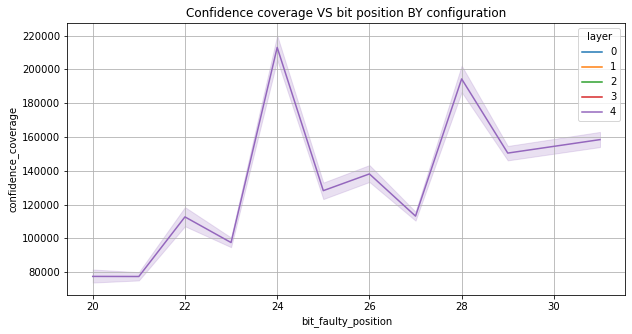

In [37]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.lineplot(ax=ax, data = general_report, x = 'bit_faulty_position', y = 'confidence_coverage', hue='layer', palette="tab10")
ax.grid()
ax.set_title("Confidence coverage VS bit position BY configuration")
